In [1]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission
from zipline.finance import slippage
from zipline.finance.slippage import SlippageModel

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import inv,pinv
from scipy.optimize import minimize

In [3]:
# risk budgeting optimization
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

# Прогружаем данные

In [4]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green');

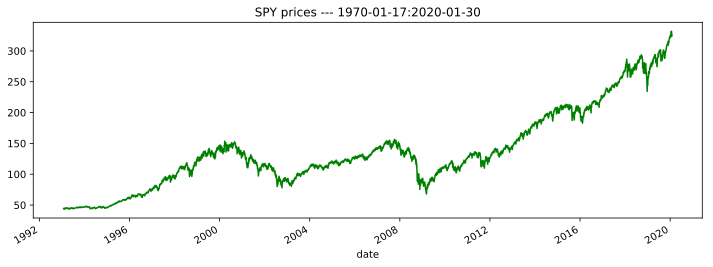

In [5]:
download_csv_data(ticker='SPY', 
                  start_date='1970-01-17', 
                  end_date='2020-01-30', 
                  freq='daily', 
                  path='data/SPY.csv')

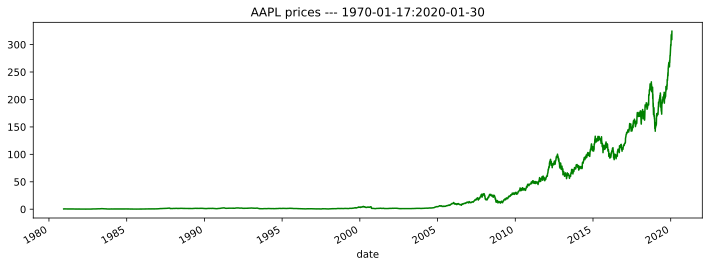

In [6]:
download_csv_data(ticker='AAPL', 
                  start_date='1970-01-17', 
                  end_date='2020-01-30', 
                  freq='daily', 
                  path='data/AAPL.csv')

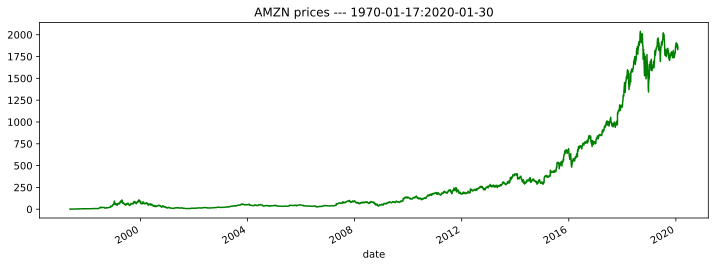

In [7]:
download_csv_data(ticker='AMZN', 
                  start_date='1970-01-17', 
                  end_date='2020-01-30', 
                  freq='daily', 
                  path='data/AMZN.csv')

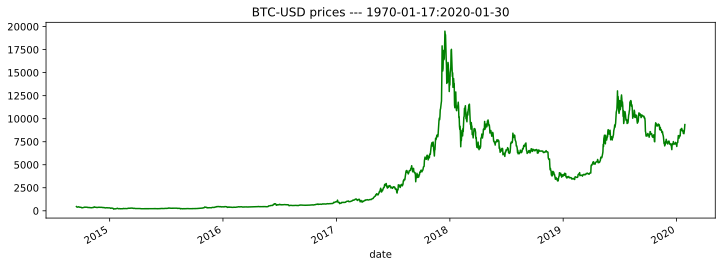

In [8]:
download_csv_data(ticker='BTC-USD', 
                  start_date='1970-01-17', 
                  end_date='2020-01-30', 
                  freq='daily', 
                  path='data/BTC.csv')

In [9]:
# Список финансовых инструментов в портфеле
TIKERS = ['SPY', 'AAPL', 'AMZN', 'BTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [10]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].head())
COLUMNS = ['open', 'close']

                 open      close
date                            
1993-01-29  26.453930  26.453930
1993-01-30  26.453930  26.453930
1993-01-31  26.453930  26.453930
1993-02-01  26.642057  26.642057
1993-02-02  26.698507  26.698507
                open     close
date                          
1980-12-12  0.407747  0.407747
1980-12-13  0.407747  0.407747
1980-12-14  0.407747  0.407747
1980-12-15  0.386473  0.386473
1980-12-16  0.358108  0.358108
                open     close
date                          
1997-05-15  1.958333  1.958333
1997-05-16  1.729167  1.729167
1997-05-17  1.729167  1.729167
1997-05-18  1.729167  1.729167
1997-05-19  1.708333  1.708333
                  open       close
date                              
2014-09-16  457.334015  457.334015
2014-09-17  424.440002  424.440002
2014-09-18  394.795990  394.795990
2014-09-19  408.903992  408.903992
2014-09-20  398.821014  398.821014


In [11]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 4 (items) x 14293 (major_axis) x 2 (minor_axis)
Items axis: SPY to BTC
Major_axis axis: 1980-12-12 00:00:00+00:00 to 2020-01-29 00:00:00+00:00
Minor_axis axis: open to close


# Взаимная корреляция

In [12]:
data_corr = data['SPY']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['close']
del data_corr['open']
del data_corr['close']
data_corr.corr()

,SPY,AAPL,AMZN,BTC
SPY,1.000000,0.951290,0.944723,0.836427
AAPL,0.951290,1.000000,0.946338,0.770029
AMZN,0.944723,0.946338,1.000000,0.793965
BTC,0.836427,0.770029,0.793965,1.000000


# Risk

### Определяем стартовые переменные

In [13]:
# Custom slippage model
class InstantSlippage(SlippageModel):
    
    def process_order(self, data, order):
        # Use price from previous bar
        price = data.history(order.sid, 'price', 2, '1d')[0]
        
        # Alternative: Use current bar's open, instead of close
        # price = data.current(order.sid, 'open')

        return (price, order.amount)

In [14]:
num_assets = len(TIKERS)
performance_list = []
COMMISSION = 0


# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

In [15]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())

    #set_benchmark(symbol('BTC'))

    context.tikers = ['SPY']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(1993, 1, 29, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 1, 29, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

SP500 = perf.algorithm_period_return

SP500 = 1000 * (1 + SP500)

SP500 = SP500.rename('S&P 500')

In [16]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())

    #set_benchmark(symbol('BTC'))

    context.tikers = ['AAPL']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(1980, 12, 12, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 1, 29, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

USBonds = perf.algorithm_period_return

USBonds = 1000 * (1 + USBonds)

USBonds = USBonds.rename('Apple')

In [17]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())

    #set_benchmark(symbol('BTC'))

    context.tikers = ['AMZN']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(1997, 5, 15, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 1, 29, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

N225 = perf.algorithm_period_return

N225 = 1000 * (1 + N225)

N225 = N225.rename('Amazon')

In [18]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())

    #set_benchmark(symbol('BTC'))

    context.tikers = ['BTC']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2014, 9, 16, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 1, 29, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

Gold = perf.algorithm_period_return

Gold = 1000 * (1 + Gold)

Gold = Gold.rename('Bitcoin')

# Визуализация результатов

In [19]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(TIKERS):
    portfolio[symbol] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock for stock in TIKERS]

# reorder dataframe columns
df = df[column_order]

In [20]:
df.head()

,Returns,Volatility,Sharpe Ratio,SPY,AAPL,AMZN,BTC
0,9.761908,18.111465,0.604908,1,0,0,0
1,20.881481,43.960781,0.655969,1,0,0,0
2,35.293306,59.360892,0.800337,1,0,0,0
3,75.457883,72.056985,1.140861,1,0,0,0


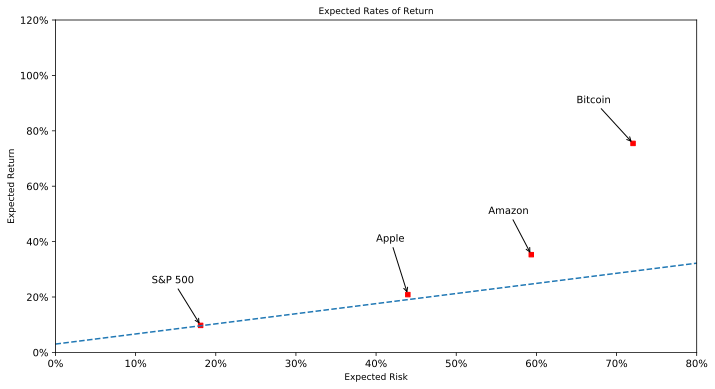

In [21]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
ax = df.plot.scatter(x='Volatility', y='Returns', marker = 's', color='r', edgecolors='r', figsize=(11.5, 6))
plt.xlabel('Expected Risk', fontsize = 9)
plt.ylabel('Expected Return', fontsize = 9)
plt.title('Expected Rates of Return', fontsize = 9)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set(xlim=(0, 80), ylim=(0, 120))

#https://matplotlib.org/3.1.1/tutorials/text/annotations.html

plt.annotate('S&P 500', xy=(df.iloc[0]['Volatility'], df.iloc[0]['Returns']), xytext=(12, 25),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Apple', xy=(df.iloc[1]['Volatility'], df.iloc[1]['Returns']), xytext=(40, 40),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Amazon', xy=(df.iloc[2]['Volatility'], df.iloc[2]['Returns']), xytext=(54, 50),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Bitcoin', xy=(df.iloc[3]['Volatility'], df.iloc[3]['Returns']), xytext=(65, 90),
             arrowprops=dict(arrowstyle="->"))

x = np.linspace(0, 80, 1000)
plt.plot(x, 3.020191 + 0.365019*x, linestyle='--')

plt.show()

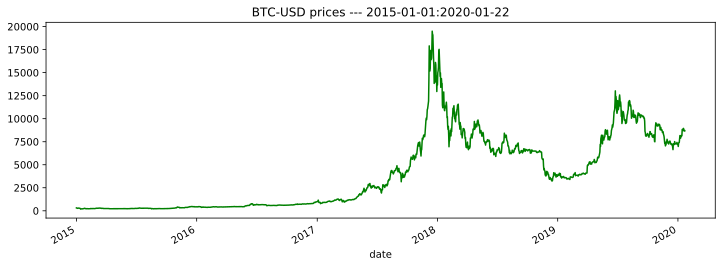

In [22]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-01-01', 
                  end_date='2020-01-22', 
                  freq='daily', 
                  path='data/BTC.csv')

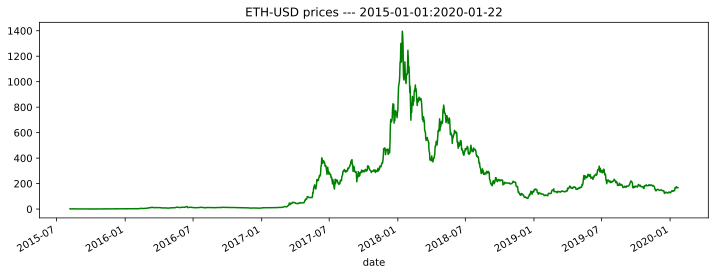

In [23]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2015-01-01', 
                  end_date='2020-01-22', 
                  freq='daily', 
                  path='data/ETH.csv')

In [24]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [25]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].head())
COLUMNS = ['open', 'close']

                  open       close
date                              
2015-01-01  314.248993  314.248993
2015-01-02  315.032013  315.032013
2015-01-03  281.082001  281.082001
2015-01-04  264.195007  264.195007
2015-01-05  274.473999  274.473999
                open     close
date                          
2015-08-06  2.772120  2.772120
2015-08-07  0.753325  0.753325
2015-08-08  0.701897  0.701897
2015-08-09  0.708448  0.708448
2015-08-10  1.067860  1.067860


In [26]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1848 (major_axis) x 2 (minor_axis)
Items axis: BTC to ETH
Major_axis axis: 2015-01-01 00:00:00+00:00 to 2020-01-22 00:00:00+00:00
Minor_axis axis: open to close


In [27]:
num_assets = len(TIKERS)
COMMISSION = 0.0007


# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

In [28]:
WEIGHTS = [0.11, 0]
TIKERS = ['BTC', 'ETH']

In [29]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())

    #set_benchmark(symbol('BTC'))

    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = WEIGHTS
    context.n_assets = len(context.assets)

    context.window = 1

    context.rebalance_period = 63
    context.time = 0

In [30]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [31]:
perf = zipline.run_algorithm(start=datetime(2015, 8, 6, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2020, 1, 16, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [32]:
performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [33]:
WEIGHTS = [0.07*2/3, 0.07/3]
TIKERS = ['BTC', 'ETH']

In [34]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())

    #set_benchmark(symbol('BTC'))

    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = WEIGHTS
    context.n_assets = len(context.assets)

    context.window = 1

    context.rebalance_period = 63
    context.time = 0

In [35]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [36]:
perf = zipline.run_algorithm(start=datetime(2015, 8, 6, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2020, 1, 16, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [37]:
performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [38]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(TIKERS):
    portfolio[symbol] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df_crypto = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock for stock in TIKERS]

# reorder dataframe columns
df_crypto = df_crypto[column_order]

In [39]:
df_crypto.head(7)

,Returns,Volatility,Sharpe Ratio,BTC,ETH
0,13.147794,10.181763,1.264300,0.110000,0.000000
1,12.994185,8.106510,1.547805,0.046667,0.023333


In [40]:
df = df.append(df_crypto, ignore_index=True)

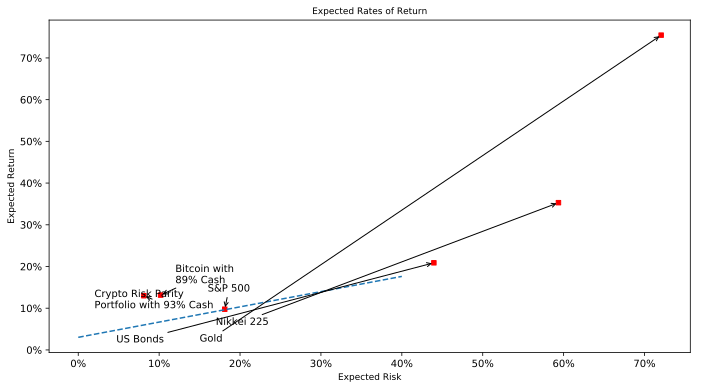

In [43]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
ax = df.plot.scatter(x='Volatility', y='Returns', marker = 's', color='r', edgecolors='r', figsize=(11.5, 6))
plt.xlabel('Expected Risk', fontsize = 9)
plt.ylabel('Expected Return', fontsize = 9)
plt.title('Expected Rates of Return', fontsize = 9)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
#ax.set(xlim=(0, 40), ylim=(0, 20))

#https://matplotlib.org/3.1.1/tutorials/text/annotations.html

plt.annotate('S&P 500', xy=(df.iloc[0]['Volatility'], df.iloc[0]['Returns']), xytext=(16, 14),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('US Bonds', xy=(df.iloc[1]['Volatility'], df.iloc[1]['Returns']), xytext=(4.7, 1.8),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Nikkei 225', xy=(df.iloc[2]['Volatility'], df.iloc[2]['Returns']), xytext=(17, 6),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Gold', xy=(df.iloc[3]['Volatility'], df.iloc[3]['Returns']), xytext=(15, 2),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Bitcoin with\n89% Cash', xy=(df.iloc[4]['Volatility'], df.iloc[4]['Returns']), xytext=(12, 16),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Crypto Risk Parity\nPortfolio with 93% Cash', xy=(df.iloc[5]['Volatility'], df.iloc[5]['Returns']), xytext=(2, 10),
             arrowprops=dict(arrowstyle="->"))



x = np.linspace(0, 40, 1000)
plt.plot(x, 3.020191 + 0.365019*x, linestyle='--')

plt.show()